<a href="https://colab.research.google.com/github/luizgontijo/DataScience_Projects/blob/master/introduction_to_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Newral Networks

**Author: Luiz Fernando da Costa Gontijo -- lz.gontijo@gmail.br**

This notebook was created to introduce the use of neural networks for the creation of predictive models.

This notebook is divided in four parts:
1. Data analysis
2. Baseline model
3. Neural network models
4. Conclusions




In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from IPython.display import display

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

import warnings

In [5]:
np.random.seed(12049)

plt.rcParams['figure.figsize'] = (12, 6)

# Data Analysis 

For the study of some neural networks classifications, we will use custumer issues datase. This dataset consists of customer complaints about products or services offered at a banking institution


In [6]:
# mount the drive to use the data contained in my repository
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# import and show the data
d = pd.read_csv('/content/drive/MyDrive/Portfólio /customer-issues.csv')
display(d.head())

,date-received,product,sub-product,issue,sub-issue,consumer-message,state,zip-code,tags,via,resolution,timely-response?,disputed?,complaint-id
0,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,AL,352XX,NaN,Web,Closed with explanation,Yes,No,2141773
1,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,PA,177XX,Older American,Web,Closed with explanation,Yes,No,2163100
2,6/15/2015,Credit reporting,NaN,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,VA,224XX,NaN,Web,Closed with explanation,Yes,No,1420702
3,2/3/2016,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,This company refuses to provide me verificatio...,TX,752XX,NaN,Web,Closed with explanation,Yes,Yes,1772196
4,2/17/2016,Debt collection,Credit card,Improper contact or sharing of info,Talked to a third party about my debt,This complaint is in regards to Square Two Fin...,NE,693XX,NaN,Web,Closed with explanation,Yes,Yes,1790634


For the classification of the issue, we will use just the consumer messager. 

In [8]:
# show four costumers messages
print(*d.loc[:4, 'consumer-message'], sep='\n\n')

I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements

I purchased a new car on XXXX XXXX. The car dealer called Citizens Bank to get a 10 day payoff on my loan, good till XXXX XXXX. The dealer sent the check the next day. When I balanced my checkbook on XXXX XXXX. I noticed that Citizens bank had taken the automatic payment out of my checking account at XXXX XXXX XXXX Bank. I called Citizens and they stated that they did not close the loan until XXXX XXXX. ( stating that they did not receive the check until XXXX. XXXX. ). I told them that I did not believe that the check took that long to arrive. XXXX told me a check was issued to me for the amount overpaid, they deducted additional interest. Today ( XXXX XXXX, ) I called Citizens Bank again and talked to a supervisor named XXXX, because on XXXX XXXX. I received a letter that the loan had b

The messages contained in this set have a temporal relationship.
It is important to separate the training / test sub-sets respecting this relationship, in order to ensure that the model is not trained on samples in the future and experienced on the past.

In [9]:
d.sort_values(by='date-received', inplace=True)

### Observe the unbalance between classes

Noting on the product frequency chart about conversations that this is an extremely unbalanced problem. There are, however, sufficient samples for modeling a topic (product) estimator taking into account the customer's dialogue.

In [10]:
def frequencies(dataset, column):
    labels, counts = np.unique(dataset[column], return_counts=True)
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]
    
    (sns
     .barplot([l[:40] for l in labels], counts)
     .set_title(f'Occurrences for The {len(labels)} Classes in {column}'))
    plt.xticks(rotation=90)
    
    return labels, counts

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


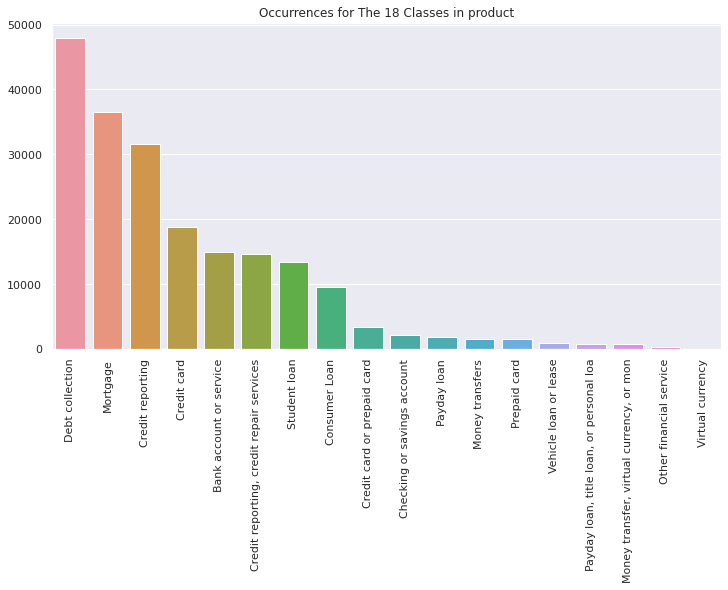

In [11]:
labels, counamts = frequencies(d, 'product')

As we saw in the last picture, there are some classes of productes with a little quantity of examples, so, we can simplify the problem and just use the six first classes.


In [12]:
s = d['product'].isin(labels[:6])
d = d[s]

Divide the data in train and test.

In [13]:
test_share = 0.3
d_train, d_test = train_test_split(d, test_size=test_share, shuffle=False)
assert d_train['date-received'].max() <= d_test['date-received'].min()

x_train, x_test = d_train['consumer-message'], d_test['consumer-message']
y_train, y_test = d_train['product'], d_test['product']

We will encode the words in the conversation using the TF-IDF, generating a vector of characteristics based on the frequency of occurrence of the words in the document and in the entire data set.

In [14]:
# imports to transform the data
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

In [15]:
# define the pipeline to make the TF-IDF transformation of the data
features = 1024

# steps: set the tfidf vectorizer than apply the standard scaler
encoder = make_pipeline(TfidfVectorizer(min_df=5,
                                        stop_words='english',
                                        strip_accents='unicode',
                                        max_features=features),
                        StandardScaler(with_mean=False))

In [16]:
x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)

label_enc = LabelEncoder()
ye_train = label_enc.fit_transform(y_train)
ye_test = label_enc.transform(y_test)

# Baseline model

To compare the results of the neural network, we first create a model based on logistic regression. In this section we apply the grid search to find the best hyperparameters of our dataset.

In [17]:
# imports to create te baseline model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [18]:
# set the seed
seed = 7
np.random.seed(seed)

In [19]:
# parameters to apply the grid search
grid_LogReg = {"C":[0.001,.009,0.01, 0.1, 1, 10, 20], 
               "penalty":['l1', 'l2']} # l1 lasso l2 ridge

In [20]:
def model_baseline(clf, params_grid):
  '''
  Function to apply de grid search on the logistic regression model
  '''
  clf = clf
  clf_LogReg_cv = GridSearchCV(clf, params_grid, cv = 5)
  grid = clf_LogReg_cv.fit(x_train, ye_train)
  return grid

In [21]:
logreg = model_baseline(LogisticRegression(), grid_LogReg);

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITER

## Evaluating some results

Some functions to show results:

print_resut - print the accuracy and the best parameters of the grid search.

plot_cm - plot the confusion matrix

conf_dist - plot the confidence distribution of the predictions.The confidence distribution indicates the certainty with which each text was classified with a certain class. For the confidence distribution courvers, if the courve is centred in 1, better the usage of the machine learning model for this class.

In [22]:
def print_results(model, y_train, y_test, x_train, x_test):
  pred_train = model.predict(x_train);
  pred_test = model.predict(x_test);
  # print best parameters and accuracy for the train and test data
  print('Best parameters: ', logreg.best_params_)
  print('Acc_train: ', accuracy_score(ye_train, pred_logReg_train).round(4))
  print('Acc_test: ', accuracy_score(ye_test, pred_logReg_test).round(4))
  print('Acc_balanced_train: ', metrics.balanced_accuracy_score(ye_train, pred_logReg_train).round(4))
  print('Acc_balanced_test: ', metrics.balanced_accuracy_score(ye_test, pred_logReg_test).round(4))


In [23]:
def plot_cm(y_true, pred, labels=None):
  '''
  Function to plot the confusion matrix
  '''
  cm = metrics.confusion_matrix(y_true, pred)
  r = cm / cm.sum(axis=1, keepdims=True)

  plt.figure(figsize=(6,5)).suptitle('Confusion Matrix', fontsize=10)
  
  sns.heatmap(r, cmap="YlGnBu", annot=True,
              xticklabels=labels, yticklabels=labels, cbar=False)

In [24]:
def conf_dist(y_true, probabilities, labels=None):
  '''
  function to plot the confidence distribution for the baseline model
  '''
  plt.figure(figsize=(10,10)).suptitle('Confidence Distribution', fontsize=10)
  for i in np.unique(y_true):
          sns.distplot(probabilities[y_true.ravel() == i][:, i],
                      hist=False,
                      label=labels[i])
  plt.legend(loc = 'best')

In [25]:
# train and test predict
pred_logReg_train = logreg.predict(x_train);
pred_logReg_test = logreg.predict(x_test);

In [26]:
# print results
print_results(model=logreg, y_train=ye_train, y_test=ye_test, x_train=x_train, x_test=x_test)

Best parameters:  {'C': 0.001, 'penalty': 'l2'}
Acc_train:  0.8424
Acc_test:  0.7568
Acc_balanced_train:  0.7616
Acc_balanced_test:  0.7329


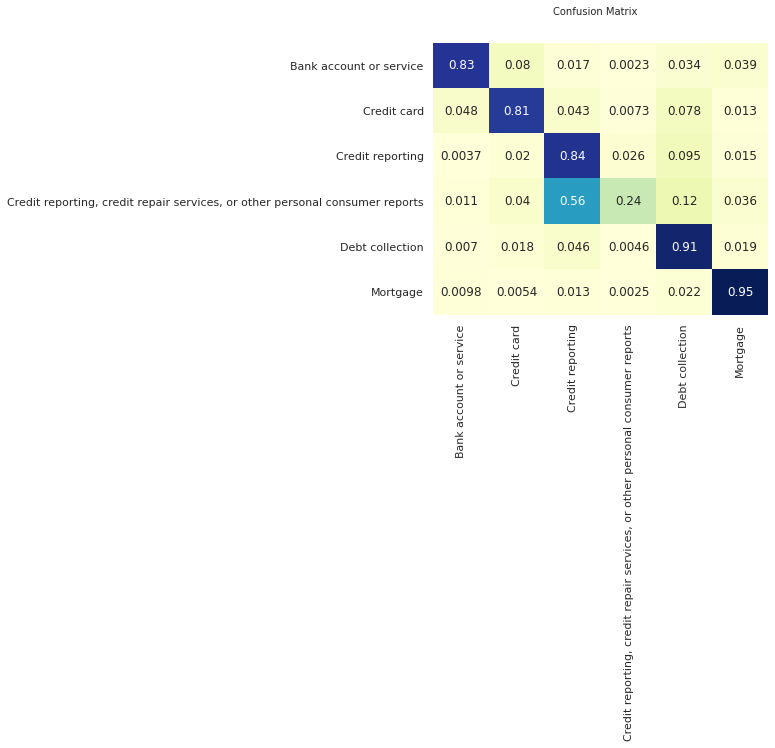

In [27]:
# confusion matrix for the train data
plot_cm(y_true=ye_train, pred=pred_logReg_train, labels=label_enc.classes_)

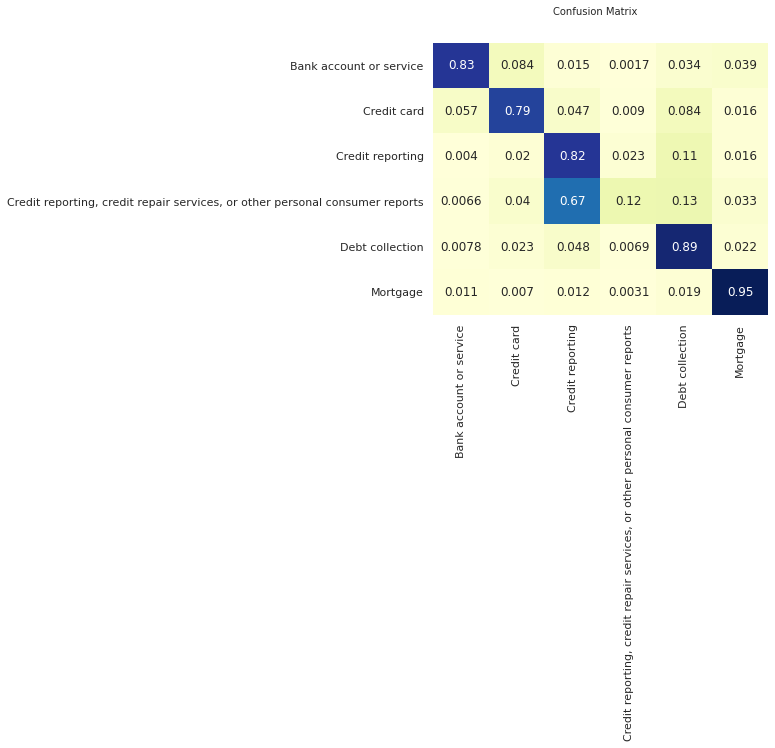

In [28]:
# confusion matrix for the test data
plot_cm(y_true=ye_test, pred=pred_logReg_test, labels=label_enc.classes_)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

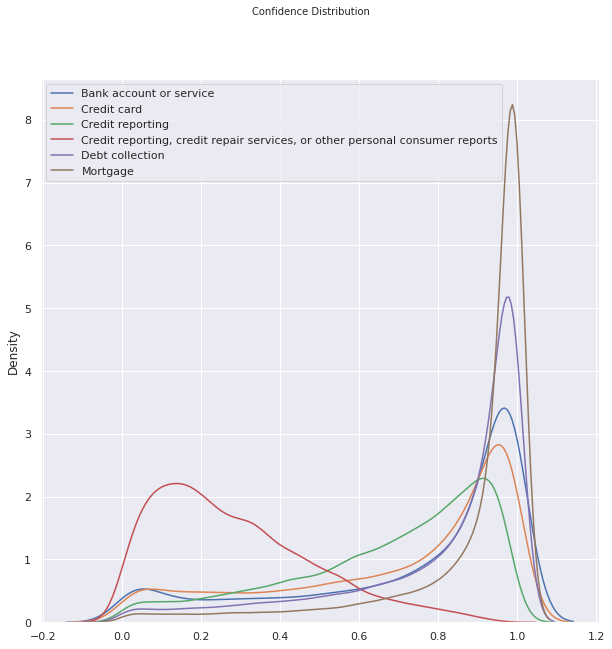

In [29]:
# confidence distribution for the train data
train_prob_logreg = logreg.predict_proba(x_train)
conf_dist(y_true=ye_train, probabilities=train_prob_logreg, labels=label_enc.classes_);

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

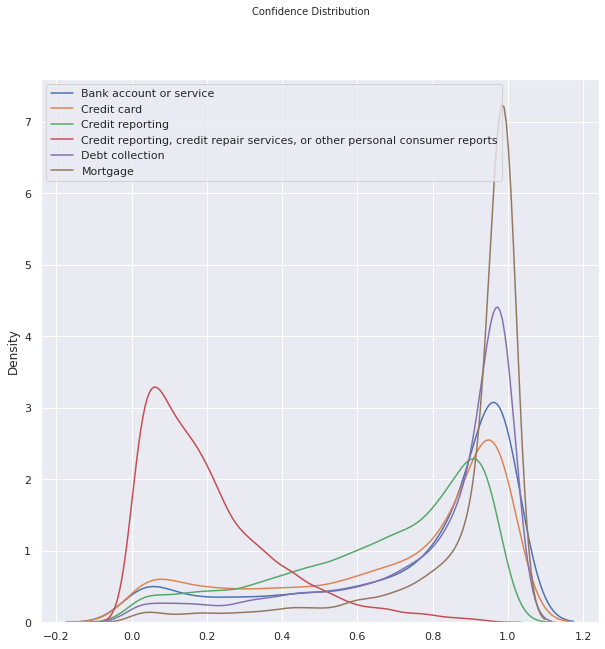

In [30]:
# confidence distribution for the test data
test_prob_logreg = logreg.predict_proba(x_test)
conf_dist(y_true=ye_test, probabilities=test_prob_logreg, labels=label_enc.classes_);

## Some conclusions about the baseline model

As can be seen from the results presented above, the Mortgage class has the highest levels of confidence. This is observed by the confidence distribution curve, which has most of its values ​​very close to 1. In addition, there was a high accuracy in the classification of the test data, as observed by the confusion matrix (95.5% correct ).

The Dept Collection, Bank Account or Service, Credit Card and Credit Reporting classes are also highly reliable. This is also observed by the confidence distribution of each of these classes, which have a distribution very close to 1.0. However, its concentration around 1.0 was not as high as the curve for the Mortgage class. It is also noted that the confusion matrix for these classes has a high hit rate, only the Credit Card category had a hit percentage below 80%, but even so with a high value of 78.7%.

The Credit Reporting, Credit Repair Services, or Other Personal Consumer Reports class showed the lowest confidence among the categories analyzed. This is observed by the distribution very close to zero, as observed by the red curve in the confidence distribution graph. In addition, it is noted, through the confusion matrix, that there were only 12.2% of correct answers for this class.

Finally, it must be concluded that there is a high level of difference in confidence between the Credit Repair Services class, or Other Personal Consumer Reports and the others. However, among the Mortgage, Dept Collection, Bank Account or Service, Credit Card and Credit Reporting classes there was not a big difference in the results of the classifications for the test data.

----------

# New model based on Neural Networks
In this section we create some Neural Network models to classify the issues used in the section above. To test different models, we vary the number of neurons and hiden layers of the models. 

In [31]:
# first some imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras import optimizers
import tensorflow as tf

import keras.callbacks
from keras.callbacks import TensorBoard
from keras import callbacks
import os
from keras import Sequential
from keras.layers import InputLayer, Dense
from keras.models import load_model

import sys

In [32]:
# as pre-processing, we need to transform the labels to categorical
from keras.utils import np_utils
y_ohe_train = np_utils.to_categorical(ye_train, num_classes=6)
y_ohe_test = np_utils.to_categorical(ye_test, num_classes=6)

In [33]:
# set epochs, batch size and input shape of the models
epochs = 3
batch_size = 128
input_shape = [features]

## Model 1
For the first model we use a neural network with 3 hidden layers. One with 512 neurons, other with 256 neuros and the last with 64 neurons. 

We use the categorical_crossentropy as loss value and SGD optimazer. 

**Atividade (1 pt):** defina uma arquitetura de uma rede neural capaz de classificar os diferentes produtos a partir da conversa dos clientes. Compile a sua rede com a loss `categorical_crossentropy`, optimizador `SGD` e defina as métricas relevantes para o problema. 

In [34]:
# Criar check poit para armazenar os pesos
#checkpoint_path = 'weights.h5'
#checkpoint_dir = os.path.dirname(checkpoint_path)

In [35]:
seed = 8
np.random.seed(seed)

In [36]:
def nw_model01(x_train, learning_rate):
  '''
  function to create te model01
  '''
  def_model = Sequential()
  
  def_model = Sequential([
      InputLayer(x_train.shape[1]),
      Dense(512, activation="relu"),
      Dense(256, activation="relu"),
      Dense(64, activation="relu"),
      Dense(6, activation="sigmoid")
  ])

  sgd = optimizers.SGD(lr=learning_rate) #lr = learning rate

  def_model.compile(optimizer=sgd,
                loss='binary_crossentropy',
                metrics=['binary_accuracy'])

  def_model.summary()
  return def_model


In [37]:
def train_model(x_train, y_train, model, save_weights, epochs, batch_size, validation_split):
  '''
  function to fit the nw model
  '''
  device = '/gpu:0'
  with tf.device(device):
      model.fit(x_train.toarray(), y_train,
                epochs = epochs,
                batch_size = batch_size,
                validation_split = validation_split,
                verbose=1,
                callbacks=[
                    callbacks.TerminateOnNaN(),
                    callbacks.ModelCheckpoint(save_weights,
                                              save_best_only=True,
                                              verbose=1),
                ])
  return model

In [38]:
def model_results(model):
  '''
  function to plot the accuracies of the model
  see the overfitting or the underfitting of the model
  '''
  history_model = pd.DataFrame(model.history.history)
  plt.figure(figsize=(16, 6))
  sns.lineplot(data=history_model.loc[:100, ['loss', 'val_loss']])

In [39]:
def save_model(model, save_path):
  '''
  function to save te model
  '''
  model_saved = model.save(save_path)
  return model_saved

In [40]:
def load_model(save_path):
  '''
  function to load the model
  '''
  model_loaded = load_model(save_path)
  return model_loaded

In [41]:
def load_model_weigths(model, path_weigths):
  '''
  function to load the model weights
  '''
  model_loaded = model.load_weights(path_weigths)
  return model_loaded

In [42]:
def save_history(model, save_path_history):
  '''
  function to save the training history of the model
  '''
  history_model = pd.DataFrame(model.history.history)
  history_model.to_csv(save_path_history)


In [43]:
def load_model_history(save_path_history):
  '''
  function to load the model history
  '''
  df = pd.read_csv(save_path_history)
  return df

In [44]:
# now create our model01 with 60 epochs
model01 = nw_model01(x_train=x_train, learning_rate = 0.01)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 672,966
Trainable params: 672,966
Non-trainable params: 0
_________________________________________________________________


In [45]:
# fit the model01
model01_train = train_model(x_train=x_train, y_train=y_ohe_train, model=model01,
            save_weights='/content/drive/MyDrive/weights.h5', 
            epochs=60, batch_size=128, validation_split=0.2)

Epoch 1/60
717/720 [============================>.] - ETA: 0s - loss: 0.4041 - binary_accuracy: 0.8339
Epoch 00001: val_loss improved from inf to 0.42765, saving model to /content/drive/MyDrive/weights.h5
720/720 [==============================] - 10s 14ms/step - loss: 0.4039 - binary_accuracy: 0.8340 - val_loss: 0.4276 - val_binary_accuracy: 0.8508
Epoch 2/60
720/720 [==============================] - ETA: 0s - loss: 0.2970 - binary_accuracy: 0.8850
Epoch 00002: val_loss improved from 0.42765 to 0.35742, saving model to /content/drive/MyDrive/weights.h5
720/720 [==============================] - 10s 13ms/step - loss: 0.2970 - binary_accuracy: 0.8850 - val_loss: 0.3574 - val_binary_accuracy: 0.8741
Epoch 3/60
716/720 [============================>.] - ETA: 0s - loss: 0.2299 - binary_accuracy: 0.9139
Epoch 00003: val_loss improved from 0.35742 to 0.32300, saving model to /content/drive/MyDrive/weights.h5
720/720 [==============================] - 10s 14ms/step - loss: 0.2297 - binary_ac

In [46]:
# save the model
save_model(model01_train, '/content/drive/MyDrive/model01.h5')

In [47]:
# save the model history
save_history(model01_train, '/content/drive/MyDrive/save_history.csv')

In [48]:
# load model history
df = load_model_history('/content/drive/MyDrive/save_history.csv')

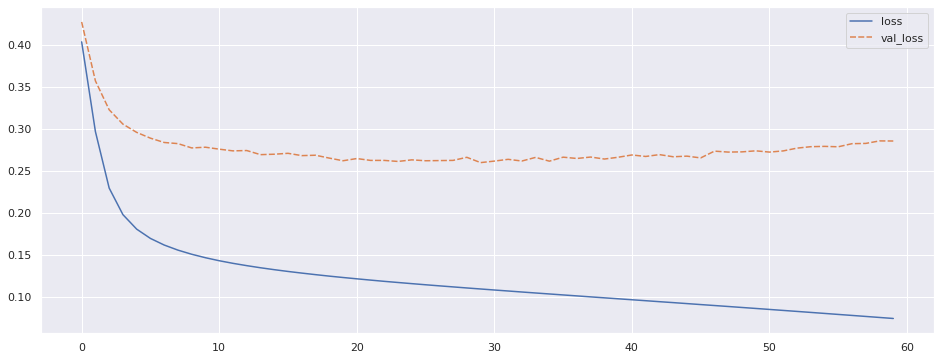

In [49]:
# see if the model has some overfitting
model_results(model01_train)

The Loss function is used to update the weights in each layer of the neural network. Its use provides the gradient decision technique used in backpropagation in the neural network training stage.

One epoch indicates the total passage of the data set through the neural network in the forward and backward directions for the training of the classification or regression model. The use of high values ​​of epochs leads to the overfitting of the model, since the neural network would be being trained several times to guarantee the minimum possible error for the training data used.

Thus, as noted in the graph above, the loss function has always decreasing values ​​for the training data (in blue); this is due to the adequacy of the model to the training data. The model's overfitting is observed when the loss value for the validation data starts to increase, that is, the curves presented for the training and validation data start to have chronological growth directions; it happens by the epoch 24. So, the weights saved refered to this epoch. 

Finally, the overfitting of the presented model starts at an epoch value equal to 24. As observed by the loss curve for the validation and training data, there is no significant change in the results for longer epochs. This indicates, therefore, that the training of the model for higher values ​​of epochs would present the super specialization of the model.




### Evaluete the Model 1

Now we can evaluete the trained model using the test dataset. For this, we use, again, accuracy values, the confusion matriz and the confidence distribution.


In [50]:
probabilities_model01_test = model01_train.predict(x_test.toarray())
probabilities_model01_train = model01_train.predict(x_train.toarray())

In [51]:
def nw_acc_scores(y_ohe_train, y_ohe_test, x_train, x_test, probabilities_train, probabilities_test):
  '''
  function to show some accuracy results
  '''
  pred_train = []
  for p in probabilities_train:
    pred_train.append(np.argmax(p))
  pred_train = np.asarray(pred_train)

  pred_test = []
  for p in probabilities_test:
    pred_test.append(np.argmax(p))
  pred_test = np.asarray(pred_test)

  y_train = []
  for cls in y_ohe_train:
    y_train.append(np.argmax(cls))
  y_train = np.asarray(y_train)

  y_test = []
  for cls in y_ohe_test:
    y_test.append(np.argmax(cls))
  y_test = np.asarray(y_test)

  # Cálculo das métricas de acerto.
  print('Acc_train:', metrics.accuracy_score(y_train, pred_train).round(3))
  print('Balanced Accuracy Train:', metrics.balanced_accuracy_score(y_train, pred_train).round(3))
  print('Acc_test:', metrics.accuracy_score(y_test, pred_test).round(3))
  print('Balanced Accuracy Test:', metrics.balanced_accuracy_score(y_test, pred_test).round(3))
    
    

In [52]:
def nw_cm(y_ohe, x, model, probabilities, labels=None):
  '''
  function to plot te confusion matrix
  '''
  pred = []
    
  for p in probabilities:
    pred.append(np.argmax(p))
  pred = np.asarray(pred)
  y = []
  for cls in y_ohe:
    y.append(np.argmax(cls))
  y = np.asarray(y)

  # Calculo da matriz de confusão.
  c = metrics.confusion_matrix(y, pred)
  r = c / c.sum(axis=1, keepdims=True)

  # Impressão dos gráficos.
  plt.figure(figsize=(5, 5)).suptitle('Confussion Matrix', fontsize=20)
  sns.heatmap(r,
              cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1%",
              xticklabels=labels, yticklabels=labels, cbar=False)

In [53]:
def nw_conf_dist(y_ohe, x, probabilities, labels=None):
  '''
  function to plot te confidence distribution
  '''
  pred = []
  for p in probabilities:
    pred.append(np.argmax(p))
  pred = np.asarray(pred)
  
  y = []
  for cls in y_ohe:
    y.append(np.argmax(cls))
  y = np.asarray(y)

  plt.figure(figsize=(10, 8)).suptitle('Confidence Distribution', fontsize=10)
  for i in np.unique(y):
    sns.distplot(probabilities[y.ravel() == i][:, i],
                 hist=False,
                 label=labels[i])
  plt.legend(loc = 'best')


In [54]:
nw_acc_scores(y_ohe_train=y_ohe_train, y_ohe_test=y_ohe_test,
              x_train=x_train, x_test=x_test,
              probabilities_train=probabilities_model01_train, probabilities_test=probabilities_model01_test)

Acc_train: 0.888
Balanced Accuracy Train: 0.8
Acc_test: 0.735
Balanced Accuracy Test: 0.711


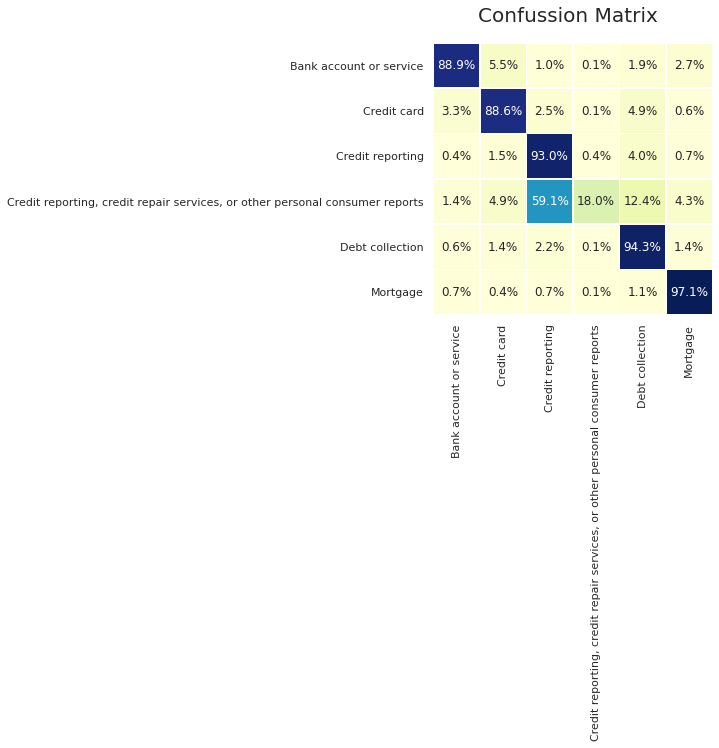

In [55]:
# confusion matrix for the train dataset
nw_cm(y_ohe=y_ohe_train, x=x_train, model=model01_train, probabilities = probabilities_model01_train, labels = label_enc.classes_)

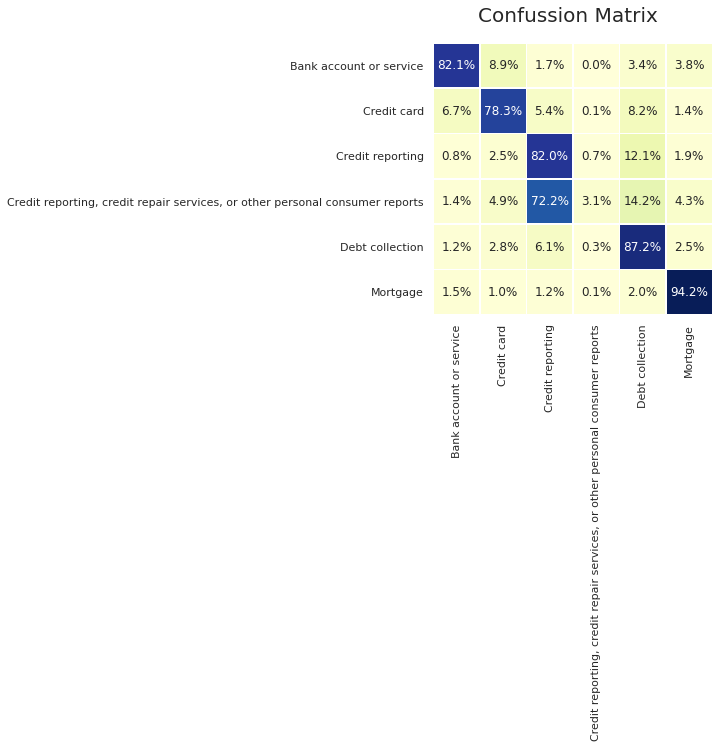

In [56]:
# confussion matrix for the test dataset
nw_cm(y_ohe=y_ohe_test, x=x_test, model=model01_train, probabilities = probabilities_model01_test, labels = label_enc.classes_)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

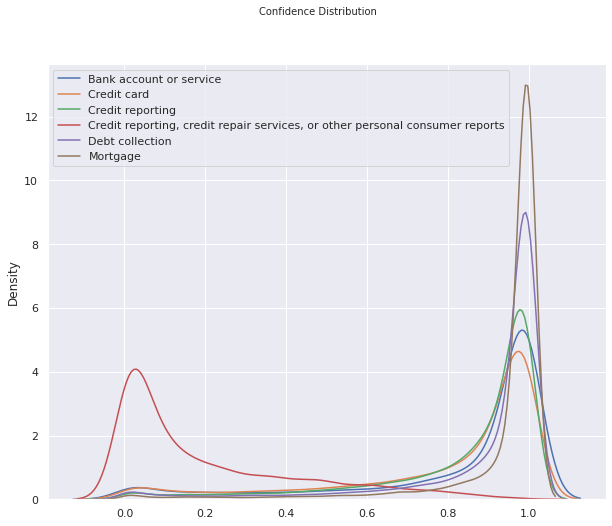

In [57]:
# confidence distribution for the train dataset
nw_conf_dist(y_ohe=y_ohe_train, x=x_train, probabilities=probabilities_model01_train, labels=label_enc.classes_)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

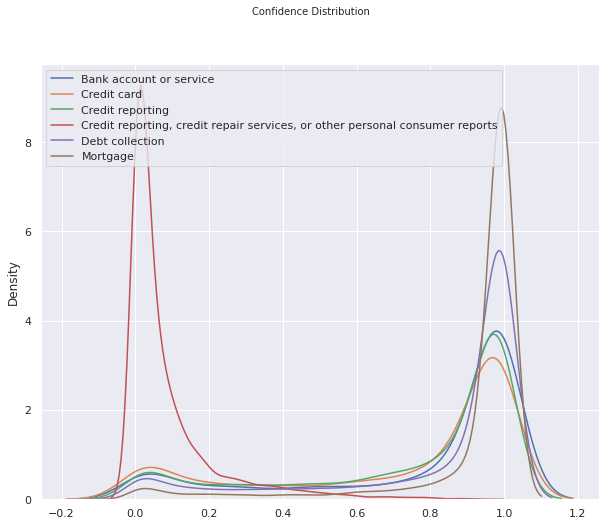

In [58]:
# confidence distribution for the test dataset
nw_conf_dist(y_ohe=y_ohe_test, x=x_test, probabilities=probabilities_model01_test, labels=label_enc.classes_)

The neural network model used presented a balanced accuracy equal to 0.734 for the test data. This value is less than the resultant for the logistic regression model (0.733).

In addition, the confidence for the test data has a distribution comparable to the results of the logistic regression: high level of difference in confidence between the Credit Repair Services class, or Other Personal Consumer Reports and the others.

## Model 2


Repita agora a definição, treinamento e avaliação de uma rede neural mais complexa, aumentando o número de camadas ou a quantidade de neurônios nas camadas da rede anterior:

**Atividade (1 pt):** defina uma rede neural mais complexa e a compile com as mesmas configurações da rede anterior.

In [59]:
def nw_model02(x_train, learning_rate):
  '''
  function to create te model01
  '''
  def_model = Sequential()
  
  def_model = Sequential([
      InputLayer(x_train.shape[1]),
      Dense(512, activation="relu"),
      Dense(256, activation="relu"),
      Dense(256, activation="relu"),
      Dense(256, activation="relu"),
      Dense(64, activation="relu"),
      Dense(6, activation="sigmoid")
  ])

  sgd = optimizers.SGD(lr=learning_rate) #lr = learning rate

  def_model.compile(optimizer=sgd,
                loss='binary_crossentropy',
                metrics=['binary_accuracy'])

  def_model.summary()
  return def_model


In [60]:
model02 = nw_model02(x_train=x_train, learning_rate=0.01)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 390       
Total params: 804,550
Trainable params: 804,550
Non-trainable params: 0
________________________________________________

In [61]:
model02_train = train_model(x_train=x_train, y_train=y_ohe_train, model=model02,
            save_weights='/content/drive/MyDrive/weights2.h5', 
            epochs=60, batch_size=batch_size, validation_split=0.2)

Epoch 1/60
719/720 [============================>.] - ETA: 0s - loss: 0.4272 - binary_accuracy: 0.8248
Epoch 00001: val_loss improved from inf to 0.46017, saving model to /content/drive/MyDrive/weights2.h5
720/720 [==============================] - 12s 17ms/step - loss: 0.4272 - binary_accuracy: 0.8248 - val_loss: 0.4602 - val_binary_accuracy: 0.8334
Epoch 2/60
719/720 [============================>.] - ETA: 0s - loss: 0.3628 - binary_accuracy: 0.8476
Epoch 00002: val_loss improved from 0.46017 to 0.39509, saving model to /content/drive/MyDrive/weights2.h5
720/720 [==============================] - 12s 17ms/step - loss: 0.3628 - binary_accuracy: 0.8476 - val_loss: 0.3951 - val_binary_accuracy: 0.8536
Epoch 3/60
717/720 [============================>.] - ETA: 0s - loss: 0.2655 - binary_accuracy: 0.8970
Epoch 00003: val_loss improved from 0.39509 to 0.33337, saving model to /content/drive/MyDrive/weights2.h5
720/720 [==============================] - 12s 16ms/step - loss: 0.2654 - binary

In [62]:
# save the model
save_model(model02_train, '/content/drive/MyDrive/model02.h5')

In [63]:
# save the model history
save_history(model02_train, '/content/drive/MyDrive/save_history02.csv')

In [64]:
# load model history
df = load_model_history('/content/drive/MyDrive/save_history02.csv')

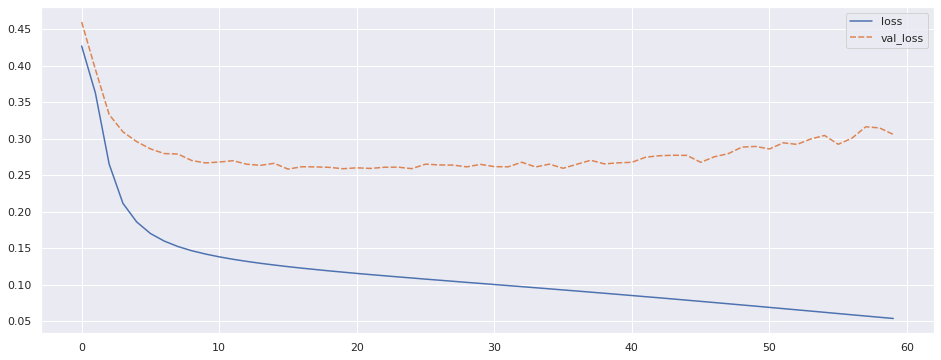

In [65]:
# see if the model has some overfitting
model_results(model02_train)

Finally, the overfitting of the presented model starts at an epoch value equal to 26. As observed by the loss curve for the validation and training data, there is no significant change in the results for longer epochs. This indicates, therefore, that the training of the model for higher values ​​of epochs would present the super specialization of the model.

### Evaluete the Model 2

As we did for the Model 1, we obtain accuracy results, the confussion matrix and the confidence distribution for the Model 2. 

In [66]:
probabilities_model02_test = model02_train.predict(x_test.toarray())
probabilities_model02_train = model02_train.predict(x_train.toarray())

In [67]:
nw_acc_scores(y_ohe_train=y_ohe_train, y_ohe_test=y_ohe_test,
              x_train=x_train, x_test=x_test,
              probabilities_train=probabilities_model02_train, probabilities_test=probabilities_model02_test)

Acc_train: 0.905
Balanced Accuracy Train: 0.818
Acc_test: 0.725
Balanced Accuracy Test: 0.703


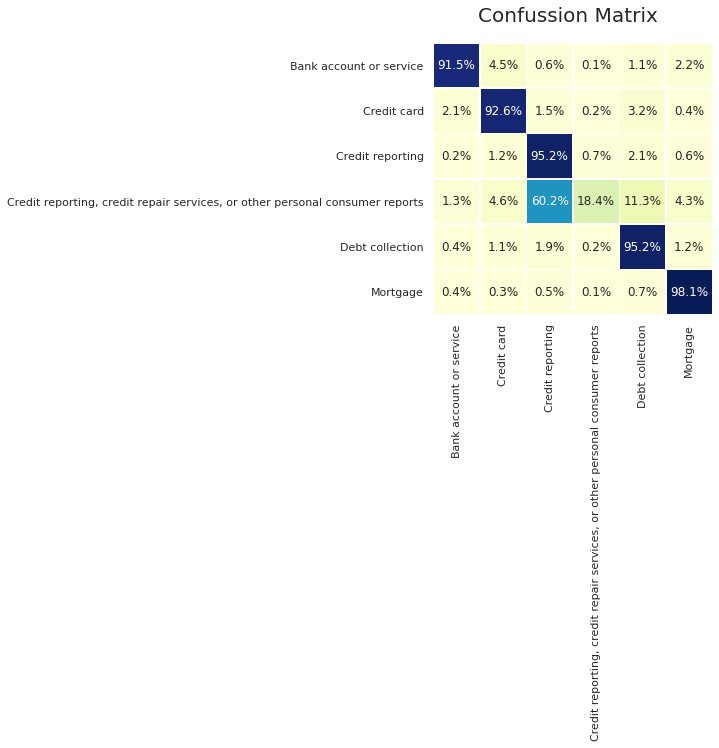

In [68]:
# confusion matrix for the train dataset
nw_cm(y_ohe=y_ohe_train, x=x_train, model=model02_train, probabilities = probabilities_model02_train, labels = label_enc.classes_)

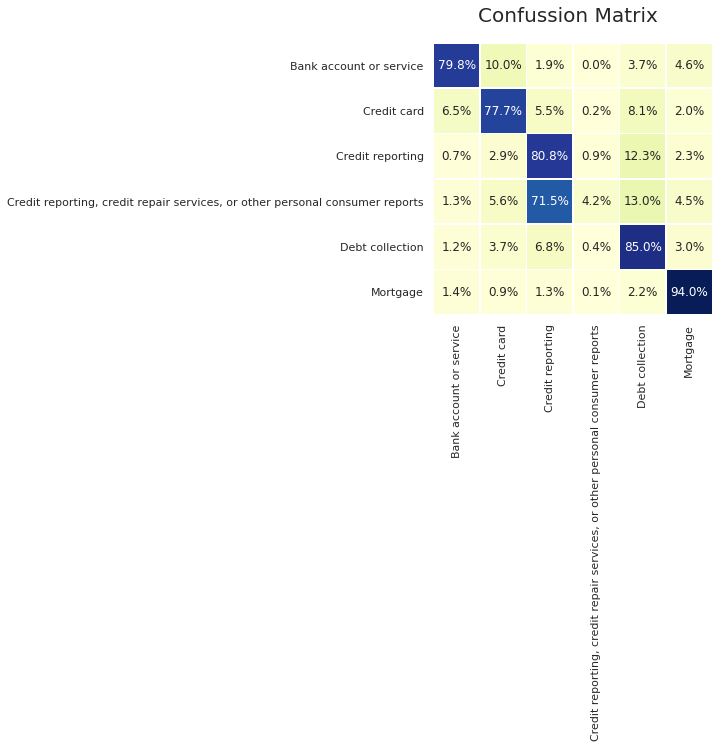

In [69]:
# confusion matrix for the train dataset
nw_cm(y_ohe=y_ohe_test, x=x_test, model=model02_train, probabilities = probabilities_model02_test, labels = label_enc.classes_)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

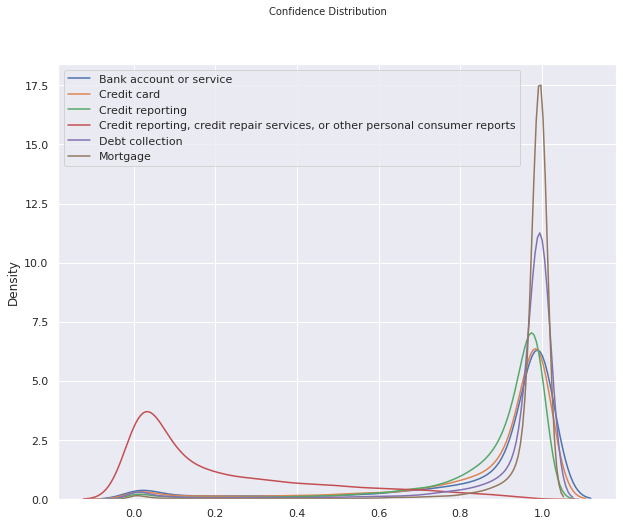

In [70]:
# confidence distribution for the test dataset
nw_conf_dist(y_ohe=y_ohe_train, x=x_train, probabilities=probabilities_model02_train, labels=label_enc.classes_)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

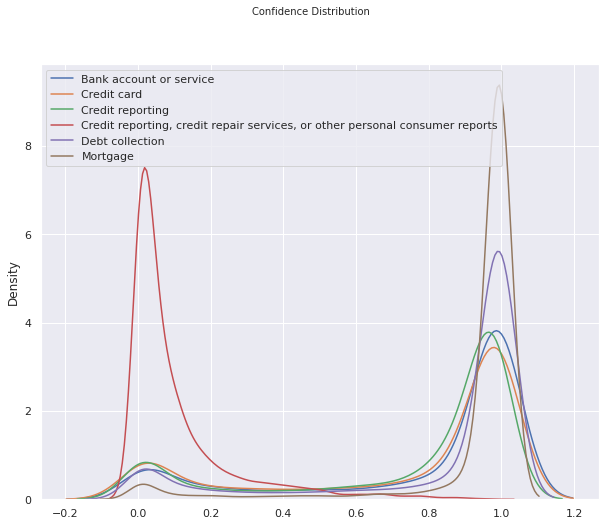

In [71]:
# confidence distribution for the test dataset
nw_conf_dist(y_ohe=y_ohe_test, x=x_test, probabilities=probabilities_model02_test, labels=label_enc.classes_)

# Conclusions


For all the models created, the 'Credit reporting, credit repair service, or other personal consumer reports' case presented the worst results. This can be seen by the confusion matrix created for the test and train dataset. 

In general, the balanced accuracy improved when we apply more complexity to the model. But, as we see by the results of this notebook, the logistic regression model had the best balanced accuracy (0.7329).

Also, the increasce of hidden layers of the neural network model did note improved the results as we expected. The worse results for neural network models can be explained by the small number of examples for training.
